<font size="+3"><strong>2. Load Data into a SQLite Database</strong></font>

In the previous notebook, we get the data from the API. In this notebook,  we'll  load our stock data into a SQLite database and then extract it for later use.

In [1]:
%%capture
!pip install python-dotenv
import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv('env')

# Use variables
ALPHA_API_KEY = os.getenv('ALPHA_API_KEY')
DB_NAME = os.getenv('DB_NAME')
MODEL_DIRECTORY = os.getenv('MODEL_DIRECTORY')

In [2]:
%load_ext autoreload
%load_ext sql
%autoreload 2

import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
from config import settings

# Building Our Data Module

For our application, we're going to keep all the classes we use to extract, transform, and load data in a single module that we'll call `data`.

## AlphaVantage API Class

In the `data` module, we created a class definition for `AlphaVantageAPI`.

In [3]:
# Import `AlphaVantageAPI`
from data import AlphaVantageAPI

# Create instance of `AlphaVantageAPI` class
av = AlphaVantageAPI()

print("av type:", type(av))

av type: <class 'data.AlphaVantageAPI'>


Then we turned the `get_daily` function we made in the last notebook into a class method.

Let's use our method to fetch the stock data for the company [HSBC Holdings plc](https://www.hsbc.com/) and assign it to the DataFrame `df_hsbc`.

In [4]:
# Define HSBA ticker symbol
ticker = "HSBA.L"

# Use our `av` object to get daily data
df_hsbc = av.get_daily(ticker=ticker)

print("df_hsbc type:", type(df_hsbc))
print("df_hsbc shape:", df_hsbc.shape)
df_hsbc.head()

df_hsbc type: <class 'pandas.core.frame.DataFrame'>
df_hsbc shape: (4743, 5)


,open,high,low,close,volume
date,,,,,
2023-09-25,639.5,643.0995,635.4,638.6,11850644.0
2023-09-22,638.1,649.5000,635.7,643.1,40235747.0
2023-09-21,630.0,640.1000,628.9,636.1,31240282.0
2023-09-20,631.8,635.7000,629.9,633.4,18482939.0
2023-09-19,626.0,631.5000,623.1,630.7,14145170.0


The next thing we need to do is test our new method to make sure it works the way we want it to.

In [5]:
# Does `get_daily` return a DataFrame?
assert isinstance(df_hsbc, pd.DataFrame)

# Does DataFrame have 5 columns?
assert df_hsbc.shape[1] == 5

# Does DataFrame have a DatetimeIndex?
assert isinstance(df_hsbc.index, pd.DatetimeIndex)

# Is the index name "date"?
assert df_hsbc.index.name == 'date'

In [6]:
# Does DataFrame have correct column names?
assert df_hsbc.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']

# Are columns correct data type?
assert all(df_hsbc.dtypes == float)

## SQL Repository Class

It wouldn't be efficient if our application needed to get data from the AlphaVantage API every time we wanted to explore our data or build a model, so we'll need to store our data in a database. Because our data is highly structured (each DataFrame we extract from AlphaVantage is always going to have the same five columns), it makes sense to use a SQL database.

We'll use SQLite for our database. For consistency, this database will always have the same name, which we've stored in our `env` file.

In [7]:
# Connect to the database whose name is stored in the env file
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)

print("connection type:", type(connection))

connection type: <class 'sqlite3.Connection'>


In [8]:
# Import class definition
from data import SQLRepository

# Create instance of class
repo = SQLRepository(connection=connection)

# Does `repo` have a "connection" attribute?
assert hasattr(repo, "connection")

# Is the "connection" attribute a SQLite `Connection`?
assert isinstance(repo.connection, sqlite3.Connection)

In [9]:
response = repo.insert_table(table_name=ticker, records=df_hsbc, if_exists="replace")

# Does your method return a dictionary?
assert isinstance(response, dict)

# Are the keys of that dictionary correct?
assert sorted(list(response.keys())) == ["records_inserted", "transaction_successful"]

Our method is passing the assert statements, we know it's returning a record of the database transaction, but we still need to check whether the data has actually been added to the database.

In [10]:
#Write a SQL query to get the first five rows of the table of HSBC data

%sql sqlite:///stocks.sqlite

In [11]:
%%sql
SELECT *
from "HSBA.L"
LIMIT 3

 * sqlite:///stocks.sqlite
Done.


date,open,high,low,close,volume
2023-09-25 00:00:00,639.5,643.0995,635.4,638.6,11850644.0
2023-09-22 00:00:00,638.1,649.5,635.7,643.1,40235747.0
2023-09-21 00:00:00,630.0,640.1,628.9,636.1,31240282.0


We can get **insert** data into our database, but let's not forget that we need to **read** data from it, too.

In [12]:
#write a SQL query to get all the HSBC data. Then use pandas to extract the data from the database and read it into a DataFrame, names df_hsbc_test
sql = " select * from 'HSBA.L'"
df_hsbc_test = pd.read_sql(
    sql = sql,
    con = connection,
    parse_dates = ["date"],
    index_col = "date"
)
print("df_hsbc_test type:", type(df_hsbc_test))
print()
print(df_hsbc_test.info())
df_hsbc_test.head()

df_hsbc_test type: <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4743 entries, 2023-09-25 to 2005-01-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4743 non-null   float64
 1   high    4743 non-null   float64
 2   low     4743 non-null   float64
 3   close   4743 non-null   float64
 4   volume  4743 non-null   float64
dtypes: float64(5)
memory usage: 222.3 KB
None


,open,high,low,close,volume
date,,,,,
2023-09-25,639.5,643.0995,635.4,638.6,11850644.0
2023-09-22,638.1,649.5000,635.7,643.1,40235747.0
2023-09-21,630.0,640.1000,628.9,636.1,31240282.0
2023-09-20,631.8,635.7000,629.9,633.4,18482939.0
2023-09-19,626.0,631.5000,623.1,630.7,14145170.0


In [13]:
# Assign `read_table` output to `df_suzlon`
df_hsbc = repo.read_table(table_name="HSBA.L", limit=2500)  # noQA F821

# Is `df_hsbc` a DataFrame?
assert isinstance(df_hsbc, pd.DataFrame)

# Does it have a `DatetimeIndex`?
assert isinstance(df_hsbc.index, pd.DatetimeIndex)

# Is the index named "date"?
assert df_hsbc.index.name == "date"

# Does it have 2,500 rows and 5 columns?
assert df_hsbc.shape == (2500, 5)

# Are the column names correct?
assert df_hsbc.columns.to_list() == ['open', 'high', 'low', 'close', 'volume']

# Are the column data types correct?
assert all(df_hsbc.dtypes == float)

# Print `df_hsbc` info
print("df_hsbc shape:", df_hsbc.shape)
print()
print(df_hsbc.info())
df_hsbc.head()

df_hsbc shape: (2500, 5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2023-09-25 to 2013-11-05
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
dtypes: float64(5)
memory usage: 117.2 KB
None


,open,high,low,close,volume
date,,,,,
2023-09-25,639.5,643.0995,635.4,638.6,11850644.0
2023-09-22,638.1,649.5000,635.7,643.1,40235747.0
2023-09-21,630.0,640.1000,628.9,636.1,31240282.0
2023-09-20,631.8,635.7000,629.9,633.4,18482939.0
2023-09-19,626.0,631.5000,623.1,630.7,14145170.0


In [14]:
def read_table(table_name, limit=None):

    """Read table from database.

    Parameters
    ----------
    table_name : str
        Name of table in SQLite database.
    limit : int, None, optional
        Number of most recent records to retrieve. If `None`, all
        records are retrieved. By default, `None`.

    Returns
    -------
    pd.DataFrame
        Index is DatetimeIndex "date". Columns are 'open', 'high',
        'low', 'close', and 'volume'. All columns are numeric.
    """
    # Create SQL query (with optional limit)
    if limit:
        sql = f" select * from '{table_name}' limit {limit}"
    else:
        sql = f" select * from '{table_name}'"


    # Retrieve data, read into DataFrame
    df = pd.read_sql(sql=sql, con=connection, parse_dates=["date"], index_col='date')

    # Return DataFrame
    return df

# Comparing Stock Returns

We already have the data for HSBC Group in our database, but we need to add the data for Tesco before we can compare the two stocks.

In [15]:
ticker = "TSCO.LON"

# Get Ambuja data using `av`
tesco_records = av.get_daily(ticker=ticker)

# Insert `ambuja_records` database using `repo`
response = repo.insert_table(
    table_name= ticker,
    records=tesco_records,
    if_exists="replace"
)
response

{'transaction_successful': True, 'records_inserted': 4731}

In [16]:
tesco_records.shape

(4731, 5)

In [17]:
ticker = "TSCO.LON"
df_tesco = repo.read_table(table_name=ticker, limit=2500)

print("df_tesco type:", type(df_tesco))
print("df_tesco shape:", df_tesco.shape)
df_tesco.head()

df_tesco type: <class 'pandas.core.frame.DataFrame'>
df_tesco shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2023-09-25,270.3,272.3000,267.400,268.8,8475620.0
2023-09-22,268.0,271.7944,267.300,270.9,14749700.0
2023-09-21,269.4,270.8000,267.951,269.5,51629281.0
2023-09-20,273.1,274.8000,268.900,270.5,16208980.0
2023-09-19,271.3,273.5000,271.000,273.1,17100000.0


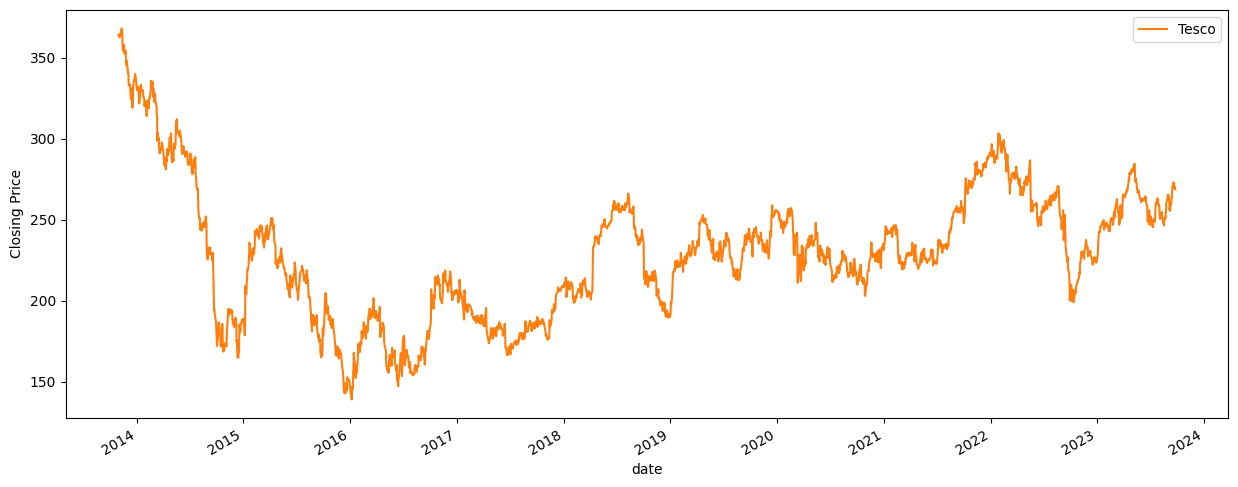

In [18]:
#Plot the closing price of df_tesco

fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_tesco` closing price
df_tesco["close"].plot(ax=ax, label="Tesco", color='C1')

# Label axes
plt.xlabel("date")
plt.ylabel("Closing Price")

# Add legend
plt.legend();

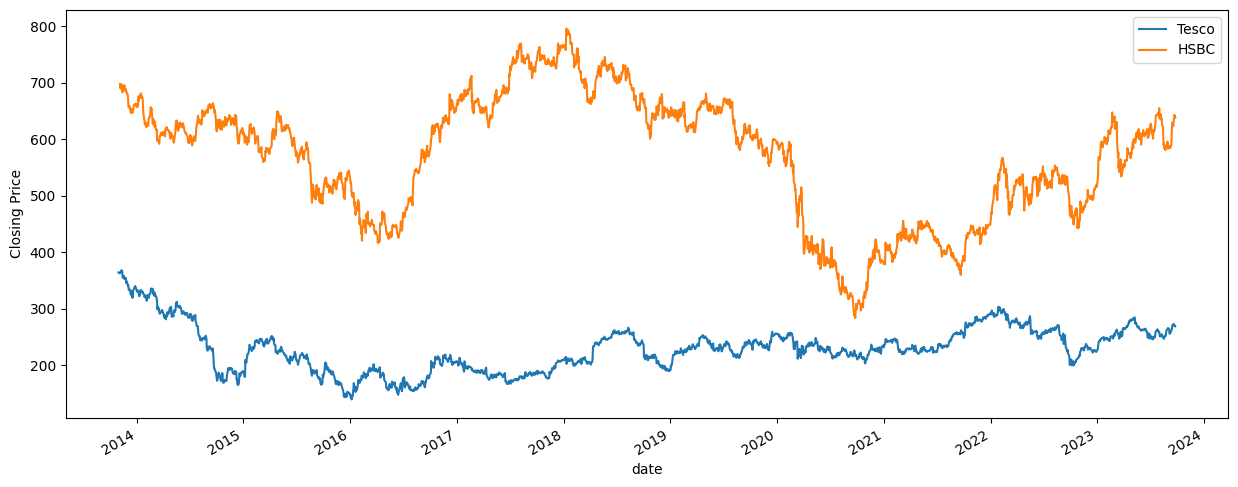

In [23]:
#Create a plot that shows the closing prices of df_hsbc and df_tesco

fig, ax = plt.subplots(figsize=(15, 6))
# Plot `df_hsbc` and `df_tesco`
df_tesco["close"].plot(ax=ax, label="Tesco")
df_hsbc["close"].plot(ax=ax, label="HSBC")

# Label axes
plt.xlabel("date")
plt.ylabel("Closing Price")


# Add legend
plt.legend();

In [20]:
# Add a "return" column to df_tesco that shows the percentage change in the "close" column from one day to the next

# Sort DataFrame ascending by date
df_tesco.sort_index(ascending=True, inplace=True)

# Create "return" column
df_tesco["return"] = df_tesco["close"].pct_change() * 100

print("df_tesco shape:", df_tesco.shape)
print(df_tesco.info())
df_tesco.head()

df_tesco shape: (2500, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2013-10-31 to 2023-09-25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
 5   return  2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB
None


,open,high,low,close,volume,return
date,,,,,,
2013-10-31,368.7001,369.8501,363.5501,364.2001,14722630.0,NaN
2013-11-01,364.3001,364.6751,362.3501,363.4001,9984376.0,-0.219659
2013-11-04,364.6001,365.4001,361.4001,362.5001,6585099.0,-0.247661
2013-11-05,363.2501,364.5501,360.3001,363.0001,9767168.0,0.137931
2013-11-06,364.2001,365.6001,363.1001,363.3501,8957066.0,0.096419


In [21]:
# Add a "return" column to df_hsbc

# Sort DataFrame ascending by date
df_hsbc.sort_index(ascending=True, inplace=True)

# Create "return" column
df_hsbc["return"] = df_hsbc["close"].pct_change() * 100

print("df_hsbc shape:", df_hsbc.shape)
print(df_hsbc.info())
df_hsbc.head()

df_hsbc shape: (2500, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2013-11-05 to 2023-09-25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2500 non-null   float64
 1   high    2500 non-null   float64
 2   low     2500 non-null   float64
 3   close   2500 non-null   float64
 4   volume  2500 non-null   float64
 5   return  2499 non-null   float64
dtypes: float64(6)
memory usage: 136.7 KB
None


,open,high,low,close,volume,return
date,,,,,,
2013-11-05,700.0,705.693,691.6,698.0,26554548.0,NaN
2013-11-06,696.4,698.300,690.7,693.5,20592015.0,-0.644699
2013-11-07,690.1,699.000,686.6,689.8,19983900.0,-0.533526
2013-11-08,685.4,696.194,682.3,695.4,21023610.0,0.811830
2013-11-11,699.3,699.300,693.4,697.0,11537964.0,0.230083


Now let's plot the returns for our two companies and see how the two compare.

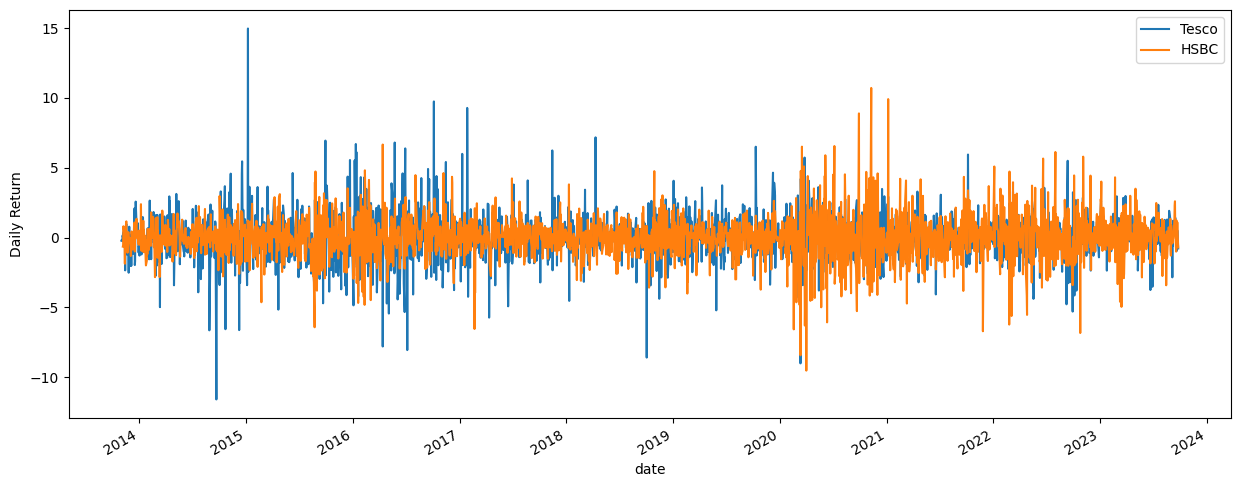

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
# Plot returns for `df_hsbc` and `df_tesco`
df_tesco["return"].plot(ax=ax, label="Tesco")
df_hsbc["return"].plot(ax=ax, label="HSBC")
#df_tesco["return"].plot(ax=ax, label="Tesco")

# Label axes
plt.xlabel("date")
plt.ylabel("Daily Return")


# Add legend
plt.legend();